# Main analysis

In [2]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [9]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [10]:
analysis_type = 'main'
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
ykey_classification = Label.DFF  # Variable of interest for post-processing

### Derived parameters

In [11]:
# Get input directory
logger.info('assembling batch analysis settings...')
# Get pre-processing, post-processing and stats IDs
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'
prepro_id = get_prepro_id(kalman_gain=kalman_gain)
postpro_id = get_postpro_id(
    neuropil_scaling_coeff, baseline_quantile, baseline_wquantile, baseline_wsmoothing)
stats_id = get_stats_id(ykey_classification)
# Get figures PDF suffix
figs_suffix = f'{analysis_type}_{prepro_id}_{postpro_id}_{stats_id}'
# Get response-type-averaged input data directory
dataroot = get_data_root()
rtypeavg_root = get_output_equivalent(dataroot, 'raw', 'rtype-averaged')
rtypeavg_dir = os.path.join(
    rtypeavg_root, stats_id, postpro_id, get_s2p_id(), prepro_id, analysis_type)
# Get figures directory
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 06/12/2022 18:01:53: assembling batch analysis settings...
 06/12/2022 18:01:53: main analysis notebook started on 2022-12-06 at 18:01:53


### Input summary table figure

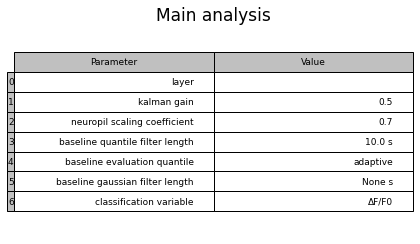

In [12]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification
    }, title='Main analysis', aspect=1.5)

### Load data

In [16]:
stats = load_rtypeavg_stats(rtypeavg_dir)
stats = stats[stats[Label.DC] > 1.]   # limit to duty cycle > 1% 
stats

 06/12/2022 18:03:30: loading data from /Users/tlemaire/Documents/data/usnm/rtype-averaged/classΔFF0/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main:
 06/12/2022 18:03:30: repsonder-type-averaged stats successfully loaded for lines line3, pv, sst


trial_length  PRF (Hz)  duration (s)   fps  P (MPa)  \
line  responder type run                                                        
line3 negative       0           100.0     100.0           0.2  3.56     0.00   
      positive       0           100.0     100.0           0.2  3.56     0.00   
      weak           0           100.0     100.0           0.2  3.56     0.00   
      negative       1           100.0     100.0           0.2  3.56     0.05   
      positive       1           100.0     100.0           0.2  3.56     0.05   
...                                ...       ...           ...   ...      ...   
sst   positive       13          100.0     100.0           0.2  3.56     0.80   
      weak           13          100.0     100.0           0.2  3.56     0.80   
      negative       14          100.0     100.0           0.2  3.56     0.80   
      positive       14          100.0     100.0           0.2  3.56     0.80   
      weak           14          100.0     100.0           0.2  3.56     0.80   

                          DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
line  responder type run                                                   
line3 negative       0      50.0   286.0        0.000000        0.000000   
      positive       0      50.0   286.0        0.000000        0.000000   
      weak           0      50.0   286.0        0.000000        0.000000   
      negative       1      50.0   292.0        0.077283        0.038642   
      positive       1      50.0   292.0        0.077283        0.038642   
...                          ...     ...             ...             ...   
sst   positive       13     70.0   129.0       19.784475       13.849133   
      weak           13     70.0   129.0       19.784475       13.849133   
      negative       14     80.0   130.0       19.784475       15.827580   
      positive       14     80.0   130.0       19.784475       15.827580   
      weak           14     80.0   130.0       19.784475       15.827580   

                          count  ...  evoked ΔF/F0 change pval - mean  \
line  responder type run         ...                                    
line3 negative       0      649  ...                         0.189500   
      positive       0     2821  ...                         0.227636   
      weak           0     2837  ...                         0.284730   
      negative       1      649  ...                         0.179164   
      positive       1     2821  ...                         0.231978   
...                         ...  ...                              ...   
sst   positive       13    1250  ...                         0.110719   
      weak           13     271  ...                         0.296138   
      negative       14      74  ...                         0.142116   
      positive       14    1250  ...                         0.143444   
      weak           14     271  ...                         0.253329   

                          evoked ΔF/F0 change pval - sem  \
line  responder type run                                   
line3 negative       0                          0.043639   
      positive       0                          0.019624   
      weak           0                          0.023155   
      negative       1                          0.046924   
      positive       1                          0.019042   
...                                                  ...   
sst   positive       13                         0.015193   
      weak           13                         0.079475   
      negative       14                         0.058107   
      positive       14                         0.016110   
      weak           14                         0.069564   

                          average displacement velocity (um/s) - mean  \
line  responder type run                                                
line3 negative       0                                       0.374561   
      positive       0           

### Plot responder type distribution per mouse line

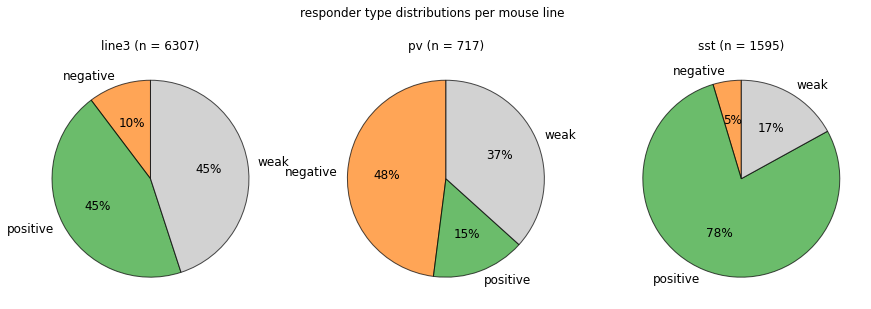

In [17]:
# Plot counts on pie chart
groups = stats.groupby(Label.LINE)
naxes = len(groups)
figs['rtype_dist_per_line'], axes = plt.subplots(1, naxes, figsize=(5 * naxes, 5))
figs['rtype_dist_per_line'].set_facecolor('w')
figs['rtype_dist_per_line'].suptitle('responder type distributions per mouse line')
for ax, (line, gdata) in zip(axes, groups):
    counts_by_rtype = gdata['count'].groupby(Label.ROI_RESP_TYPE).first()
    ax.set_title(f'{line} (n = {counts_by_rtype.sum()})')
    counts_by_rtype.plot.pie(
        ax=ax, ylabel='', autopct='%1.0f%%',
        colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
        startangle=90, textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'k', 'alpha': 0.7}
    )

### Plot parameter dependency curves 

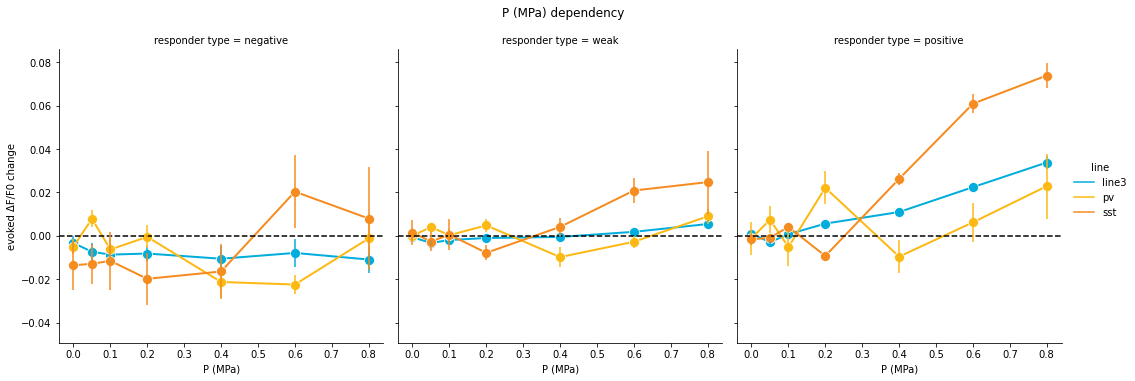

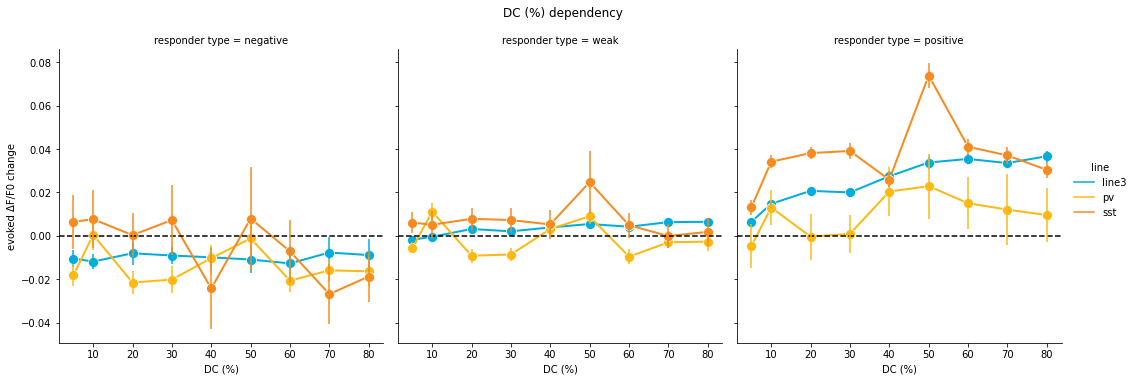

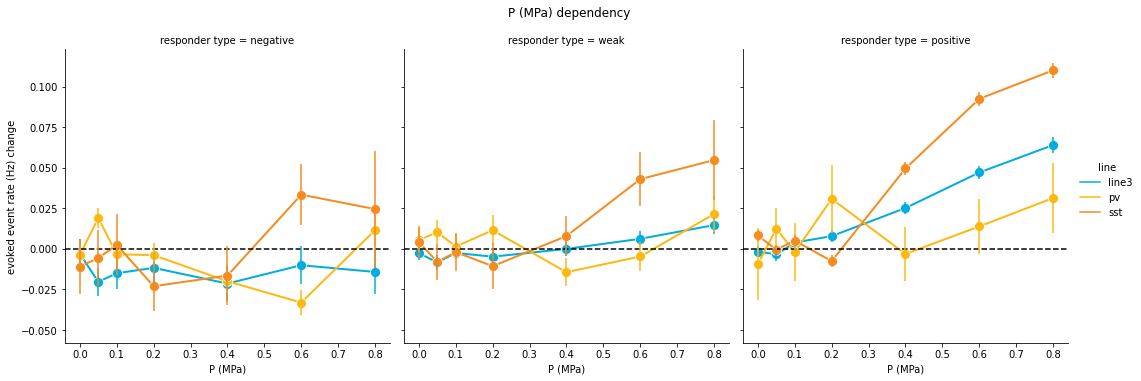

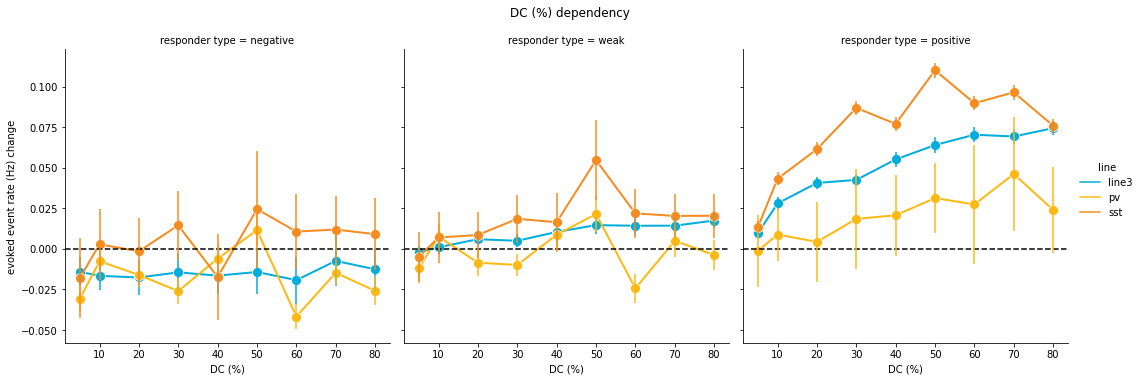

In [18]:
for ykey in [Label.DFF, Label.EVENT_RATE]:
    tmpaxes = []
    for xkey in [Label.P, Label.DC]:
        figkey = f'{ykey}_{xkey} dep'
        figs[figkey] = plot_parameter_dependency_across_lines(
            stats, xkey, get_change_key(ykey))
        tmpaxes = tmpaxes + figs[figkey].axes
    harmonize_axes_limits(np.asarray(tmpaxes))

### Plot Ispta dependency curves

 16/11/2022 20:40:05: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 16/11/2022 20:40:05: plotting evoked event rate (Hz) change ISPTA dependency across responders...


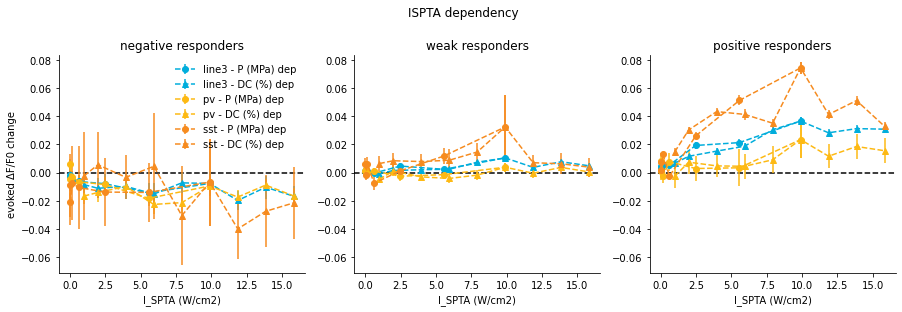

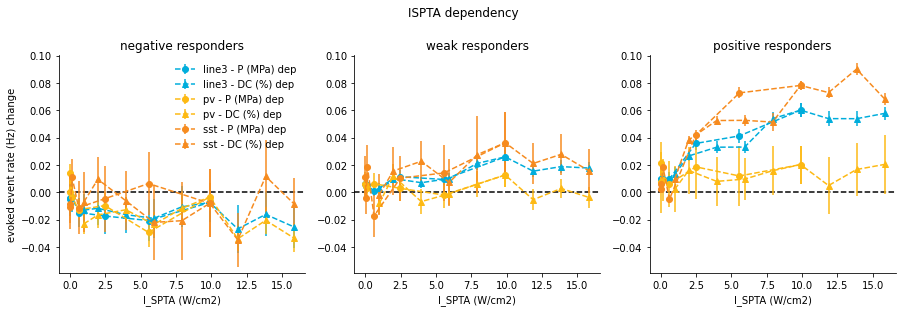

In [12]:
for ykey, ax in zip([Label.DFF, Label.EVENT_RATE], axes):
    figs[f'ispta_{ykey}_deps'] = plot_intensity_dependencies_across_lines(
        stats, get_change_key(ykey))

### Save figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 16/11/2022 20:40:07: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.11.16/figs_main_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 8/8 [00:01<00:00,  7.31it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'main analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 16/11/2022 20:39:40: main analysis notebook completed in 0:00:03.976159 s
